# Goal
Almost all sites have a user referral program where you can invite new users to try a given product. Typically, after the new user completes a transaction, you get rewarded with a certain amount of money or credit to be used on the site.

The goal of this challenge is to analyze the data from a referral program and draw conclusions about its effectiveness.

# Challenge Description
Company XYZ has started a new referral program on Oct, 31. Each user who refers a new user will get 10$ in credit when the new user buys something.
The program has been running for almost a month and the Growth Product Manager wants to know if it’s been successful. She is very excited because, since the referral program started, the company saw a spike in number of users and wants you to be able to give her some data she can show to her boss.

Can you estimate the impact the program had on the site? Based on the data, what would you suggest to do as a next step? The referral program wasn’t really tested in a rigorous way. It simply started on a given day for all users and you are drawing conclusions by looking at the data before and after the test started. What kinds of risks this approach presents? Can you think of a better way to test the program and measure its impact?
# Data
We have just 1 table downloadable by clicking here.

# The table is:
referral - provides information about each transaction that happens on the site and whether the user came from the referral program or not.

Columns:

user_id : the id of the user date : date of the purchase country : user country based on the ip address money_spent : how much the item bought costs(USD) is_referral : whether the user came from the referral program (1) or not (0) device_id : Id of the device used to make the purchase

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
import matplotlib.dates as mdates


In [82]:
url = 'https://drive.google.com/uc?export=download&id=18qT5bGXcUKxMwfZG7YzTiHCGs_y2WoOK'
data = pd.read_csv(url)


# Descriptive Stats

In [83]:
data.shape


(97341, 6)

In [84]:
data['date'] = pd.to_datetime(data['date'])
data.dtypes

user_id                 int64
date           datetime64[ns]
country                object
money_spent             int64
is_referral             int64
device_id              object
dtype: object

In [85]:
data.describe()

,user_id,date,money_spent,is_referral
count,97341.000000,97341,97341.000000,97341.000000
mean,6354.801029,2015-10-30 02:52:35.644589568,44.692360,0.287823
min,1.000000,2015-10-03 00:00:00,10.000000,0.000000
25%,2020.000000,2015-10-17 00:00:00,27.000000,0.000000
50%,4053.000000,2015-10-31 00:00:00,42.000000,0.000000
75%,10286.000000,2015-11-14 00:00:00,59.000000,1.000000
max,20000.000000,2015-11-27 00:00:00,220.000000,1.000000
std,5682.991186,NaN,22.791839,0.452751


# Clean Data

In [86]:
i = data[data['date'] < '2015-10-31 00:00:00' ].index
print(round(len(i)/len(data)*100),"pct of rows are from before the implementation \n")

# find count of referal before vs after implementation - to make sure no users were referred before
print("before implementation")
print(data.query('date<\'2015-10-30\'')['is_referral'].value_counts(),"\n\n")

print("after implementation")
print(data.query('date>=\'2015-10-30\'')['is_referral'].value_counts())

49 pct of rows are from before the implementation 

before implementation
is_referral
0    46153
Name: count, dtype: int64 


after implementation
is_referral
1    28017
0    23171
Name: count, dtype: int64


In [87]:
# check is_referal by user id
print(data.groupby('user_id').is_referral.nunique().sort_values(ascending=False).head(5),"\n\n")
print(len(data.groupby('user_id').is_referral.nunique().sort_values(ascending=False)),"rows are weird \n\n")

print(data.query('user_id == 9776'))

# 

user_id
9776     2
6639     2
13642    2
6661     2
6660     2
Name: is_referral, dtype: int64 


18809 rows are weird 


       user_id       date country  money_spent  is_referral      device_id
61364     9776 2015-11-07      CA           53            0  UWKROJTCYNTHF
61365     9776 2015-11-07      CA           15            1  UWKROJTCYNTHF
94319     9776 2015-11-25      ES           20            0  UWKROJTCYNTHF


### some thing is wrong above: a user cannot be referred and not referred at the same time. 
### too many rows to just drop. we are going to assign the first value for all other transactions

In [88]:
print(data['date'].is_monotonic_increasing)
data['is_referral'] = data.groupby('user_id')['is_referral'].transform('first')
print("max is_referral assignment by user:",data.groupby('user_id').is_referral.nunique().max())


True
max is_referral assignment by user: 1


# Can you estimate the impact the program had on the site?

Text(0, 0.5, '# unique users')

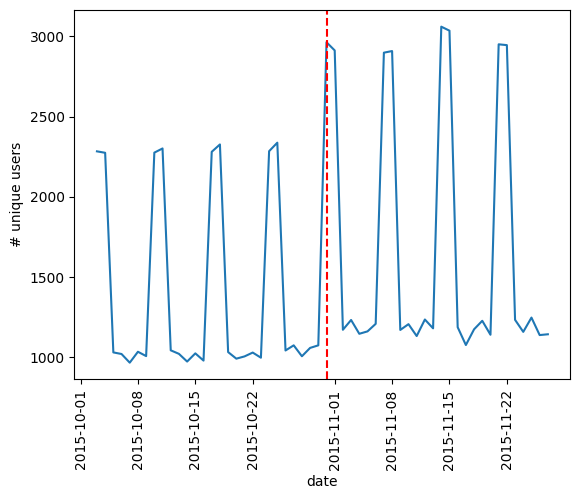

In [89]:
plt.plot(data.groupby('date').user_id.nunique())
plt.axvline(x = pd.to_datetime('2015-10-31 00:00:00'), color = 'r', linestyle = '--')
plt.xticks(rotation = 90)
plt.xlabel('date')
plt.ylabel('# unique users')

### on and after implementation, amount of users went up. good.

Text(0, 0.5, '# unique users')

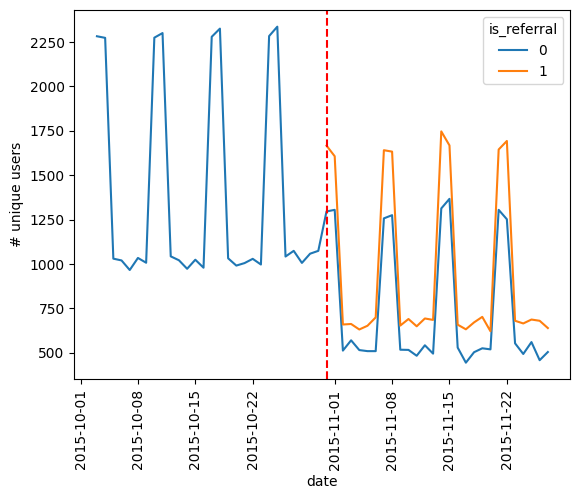

In [90]:
plt_data = data.groupby(['date','is_referral'])['user_id'].nunique().reset_index()

sns.lineplot(data=plt_data, x = 'date', y = 'user_id', hue = 'is_referral')

plt.axvline(x = pd.to_datetime('2015-10-31 00:00:00'), color = 'r', linestyle = '--')
plt.xticks(rotation = 90)
plt.xlabel('date')
plt.ylabel('# unique users')

### first look: there are more referred users than non-referred users
### but then there's a drop in non-referred users. is this cannibalization? let's check

Text(0, 0.5, 'revenue')

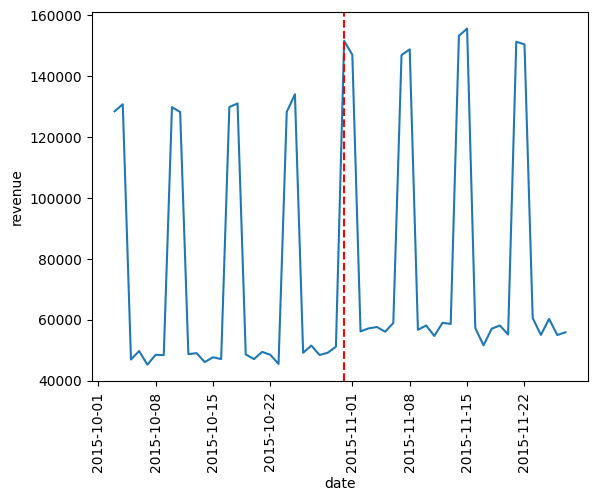

In [91]:
plt.plot(data.groupby('date').money_spent.sum())

plt.axvline(x = pd.to_datetime('2015-10-31 00:00:00'), color = 'r', linestyle = '--')
plt.xticks(rotation = 90)
plt.xlabel('date')
plt.ylabel('revenue')

Text(0, 0.5, 'revenue')

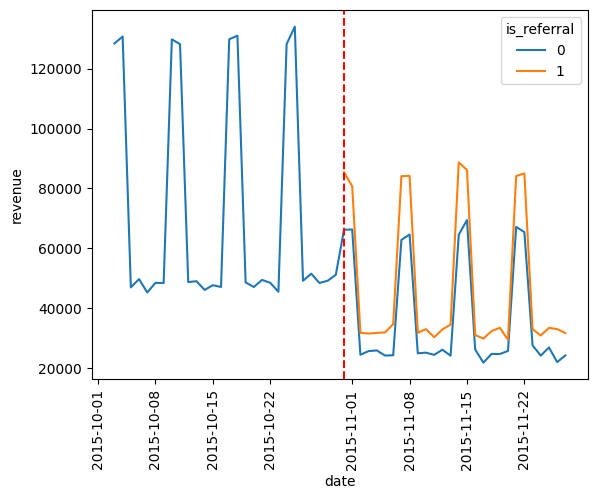

In [92]:
plt_data2 = data.groupby(['date','is_referral']).money_spent.sum().reset_index()


sns.lineplot(data = plt_data2, x = 'date', y = 'money_spent', hue = 'is_referral')
plt.axvline(x = pd.to_datetime('2015-10-31 00:00:00'), color = 'r', linestyle = '--')
plt.xticks(rotation = 90)
plt.xlabel('date')
plt.ylabel('revenue')

### revenue graph looks very similar to # of users graph - possible cannibalization
### let's drill down to devices and see what happens

Text(0, 0.5, 'devices vs. users')

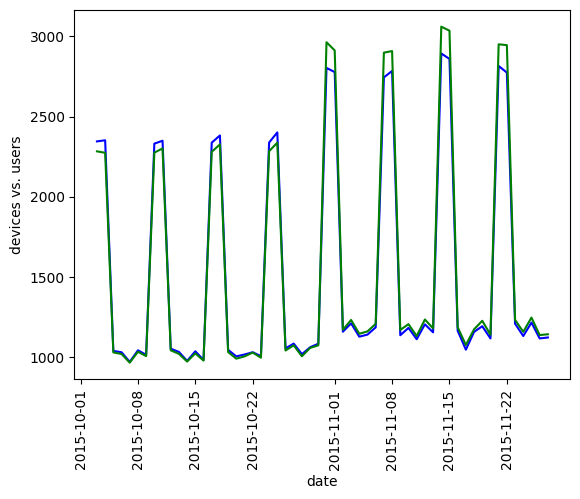

In [93]:
plt.plot(data.groupby('date').device_id.nunique(),color = 'blue')
plt.plot(data.groupby('date').user_id.nunique(),color = 'green')


plt.xticks(rotation = 90)
plt.xlabel('date')
plt.ylabel('devices vs. users')

### users have more accounts after the implementation than before.
### hard to isolate the impact of the pragram alone. Data is messy because users went and created new accounts to take advantage of the new program. Estimation is not accurate. Let's estimate anyways.

11:23:16 - cmdstanpy - INFO - Chain [1] start processing
11:23:17 - cmdstanpy - INFO - Chain [1] done processing


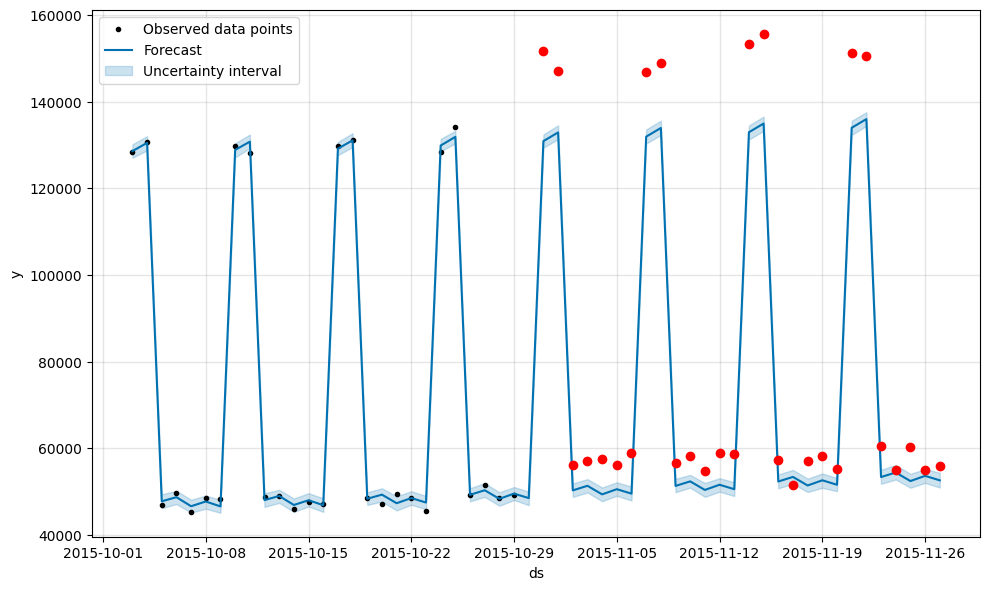

In [94]:
from prophet import Prophet

ts_data = data.query('date<\'2015-10-30\'').groupby('date').money_spent.sum().reset_index()
# ts_data['date'] = (ts_data['date'] - min(ts_data['date'])).dt.days
ts_data.rename({'date':'ds',
                'money_spent': 'y'},
                axis = 1,
                inplace=True)

model = Prophet()
model.fit(ts_data)

# of days to predict
days_predict = (data['date'].max() - ts_data['ds'].max()).days

# make predictions
future_data = model.make_future_dataframe(periods=days_predict)
predictions = model.predict(future_data)

model.plot(predictions);
plt.plot(data.query('date>\'2015-10-30\'').groupby('date').money_spent.sum(),'o', color = 'red')
plt.legend()
# print(predictions)
# predictions.describe()

### actual data points are above prediction data points, often above 95% interval of the prediction.

In [95]:
mean_actual = round(data.query('date>\'2015-10-30\'').groupby('date').money_spent.sum().mean())
mean_prediction = round(predictions.query('ds>\'2015-10-30\'')['yhat'].mean())
# round(predictions.query('ds>\'2015-10-30\'')['yhat'].mean())
# print(predictions)
print(mean_actual,"\n",
      mean_prediction,"\n",
      "pct differnence", round(100* (mean_actual/mean_prediction -1)))

83714 
 75089 
 pct differnence 11


In [101]:
test = stats.ttest_rel(data.query('date>\'2015-10-30\'').groupby('date')['money_spent'].sum(), 
                       predictions.query('ds>\'2015-10-30\'')['yhat']
                       )

print(format(test.pvalue,'.10f'))

0.0000000605


# Conclusion
### Can you estimate the impact the program had on the site? 

our estimation is not accurate at all, given data suggests users went and created new accounts to take advantage of the program. Additionally, data logging has problems - some users are both referred and non-referred. It needs to be fixed.

But with the messy data, we saw that the program did bring in more revenue.

### Based on the data, what would you suggest to do as a next step? 
1. fix data logging
2. try to prevent user from referring themselves
3. calculate user lifetime value, so can use it calculate profit instead of just revenue
4. collect more historical data. we have only data from oct to nov 2015. we cannot see seasonality with such little historical data
5. redesign the experiment to ensure statistical soundness


### What kinds of risks this approach presents? Can you think of a better way to test the program and measure its impact?
1. we are not isolating the impact of the program alone. other things may have influenced the change, such as seasonality, network effect, other changes to the site, etc etc
2. we should test by market instead